### Phase analysis - General Approach

Apply analysis to all channels and pairs over all frequency bands. Analywe distributions of instantaneous phase differences as a function of epoch and stimulusm for all channels.

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircular
import scipy
import seaborn as sns
import xarray as xr
from frites.conn import conn_reshape_undirected
from scipy.signal import find_peaks
from scipy.stats import circmean, circstd, circvar
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from xarray_einstats.stats import circmean, circstd

from src.signal.surrogates import trial_swap_surrogates
from src.util import _extract_roi

In [3]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [4]:
def detect_peak_frequencies(power=None, prominence=0.01, verbose=False):

    assert power.ndim == 2
    assert isinstance(power, xr.DataArray)

    roi, freqs = power.roi.data, power.freqs.data
    n_roi = len(roi)

    rois = []
    peak_freqs = []
    peak_prominences = []

    __iter = range(n_roi)
    for i in tqdm(__iter) if verbose else __iter:
        peak_index, peak_info = find_peaks(power[i, :], prominence=prominence)
        peak_freqs += [freqs[peak_index]]
        peak_prominences += [peak_info["prominences"]]
        rois += [[roi[i]] * len(peak_index)]

    return peak_freqs, peak_prominences, rois

In [5]:
def find_start_end(array, find_zeros=False):
    """
    Given a binary array find the indexes where the sequences of ones start
    and begin if find_zeros is False. Otherwise it will find the indexes where
    the sequences of zeros start and begin. For instance, for the array
    [0,1,1,1,0,0], would return 1 and 3 respectively for find_zeros=False,
    and 1 and 2 for find_zeros=True.

    Parameters
    ----------
    array: array_like
        Binary array.
    find_zeros: bool | False
        Wheter to find a sequence of zeros or ones

    Returns
    -------
    The matrix containing the start anb ending index
    for each sequence of consecutive ones or zeros with shapes [n_seqs,2]
    where n_seqs is the number of sequences found.
    """
    if find_zeros:
        _bounds = np.array([1])
    else:
        _bounds = np.array([0])

    bounded = np.hstack((_bounds, array, _bounds))
    difs = np.diff(bounded)
    # get 1 at run starts and -1 at run ends if find_zeros is False
    if not find_zeros:
        (run_starts,) = np.where(difs > 0)
        (run_ends,) = np.where(difs < 0)
    # get -1 at run starts and 1 at run ends if find_zeros is True
    else:
        (run_starts,) = np.where(difs < 0)
        (run_ends,) = np.where(difs > 0)
    return np.vstack((run_starts, run_ends)).T


def find_activation_sequences(spike_train, find_zeros=False, dt=None, pad=False):
    """
    Given a spike-train, it finds the length of all activations in it.
    For example, for the following spike-train: x = {0111000011000011111},
    the array with the corresponding sequences of activations (ones) will be
    returned: [3, 2, 5] (times dt if this parameter is provided).

    Parameters
    ----------
    spike_train: array_like
        The binary spike train.
    find_zeros: bool | False
        Wheter to find a sequence of zeros or ones
    dt: int | None
        If provided the returned array with the length of activations
        will be given in seconds.

    Returns
    -------
    act_lengths: array_like
        Array containing the length of activations with shape [n_seqs]
        where n_seqs is the number of sequences found.
    """

    # If no dt is specified it is set to 1
    if dt is None:
        dt = 1
    out = find_start_end(spike_train, find_zeros=find_zeros)
    act_lengths = (out[:, 1] - out[:, 0]) * dt

    if pad:
        _new_size = len(spike_train) // 2 + 1
        act_lengths = _nan_pad(act_lengths, _new_size, 0)

    return act_lengths

#### Load data

In [6]:
band = 1

In [7]:
DATA_PATH = os.path.expanduser(
    "/home/vinicius/funcog/phaseanalysis/Results/lucy/141017"
)

average_power_epochs = xr.load_dataarray(os.path.join(DATA_PATH, "average_power.nc"))

power_time_series = xr.load_dataarray(
    os.path.join(DATA_PATH, f"power_time_series_band_{band}_surr_False.nc")
)

phase_time_series = xr.load_dataarray(
    os.path.join(DATA_PATH, f"phase_time_series_band_{band}_surr_False.nc")
)

phi_series = xr.load_dataarray(
    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_False.nc")
)

phi_series_surr = xr.load_dataarray(
    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_True.nc")
)

#### Compute white matters distances

In [9]:
wmd = pd.read_excel(
    "/home/vinicius/Documents/WhiteMatterDistance.xlsx", index_col=0
).fillna(0)

/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [10]:
# White matter distances

pairs = phi_series.roi.values

rois_ch_s, rois_ch_t = _extract_roi(pairs, "-")

_, rois_s = _extract_roi(rois_ch_s, "_")
_, rois_t = _extract_roi(rois_ch_t, "_")

wmd_pairs = []
for s, t in zip(rois_s, rois_t):
    wmd_pairs += [wmd.loc[wmd.index == s, wmd.columns == t].values]

wmd_pairs = xr.DataArray(
    np.hstack(wmd_pairs).squeeze(), dims=("roi"), coords={"roi": pairs}, name="wmd"
)

In [11]:
# Define the matrix using ranges where necessary
xy_grid_lucy = [
    [0, 0, 0, 0, 0, 0] + list(range(248, 253)),
    [0, 0, 0, 0, 0] + list(range(242, 248)),
    [0, 0, 0] + list(range(234, 242)),
    [0, 0] + list(range(225, 234)),
    [0, 0] + list(range(216, 225)),
    [0] + list(range(206, 216)),
    list(range(195, 206)),
    list(range(184, 195)),
    list(range(173, 184)),
    list(range(162, 173)),
    list(range(151, 162)),
    list(range(140, 151)),
    list(range(129, 140)),
    list(range(118, 129)),
    list(range(107, 118)),
    list(range(96, 107)),
    list(range(85, 96)),
    list(range(74, 85)),
    [0] + list(range(64, 74)),
    [0, 0] + list(range(55, 64)),
    [0, 0] + list(range(46, 55)),
    [0, 0] + list(range(37, 46)),
    [0, 0, 0] + list(range(29, 37)),
    [0, 0, 0] + list(range(21, 29)),
    [0, 0, 0, 0, 0] + list(range(15, 21)),
    [0, 0, 0, 0, 0] + list(range(9, 15)),
    [0, 0, 0, 0, 0, 0, 0] + list(range(5, 9)),
    [0, 0, 0, 0, 0, 0, 0] + list(range(1, 5)),
]

# Convert to NumPy array and transpose
xy_grid_lucy = np.array(xy_grid_lucy).T

In [12]:
power_time_series.attrs["xp"] = np.zeros(power_time_series.sizes["roi"])
power_time_series.attrs["yp"] = np.zeros(power_time_series.sizes["roi"])

for pos, c in enumerate(power_time_series.attrs["channels_labels"]):
    x, y = np.where(xy_grid_lucy == c)
    power_time_series.attrs["xp"][pos] = x[0] * 2.3
    power_time_series.attrs["yp"][pos] = y[0] * 2.3

In [13]:
xyz = np.stack(
    (
        power_time_series.attrs["xp"],
        power_time_series.attrs["yp"],
        power_time_series.attrs["z"][power_time_series.attrs["indch"]] / 1000,
    ),
    axis=1,
)

In [14]:
ed = pd.DataFrame(
    euclidean_distances(xyz),
    index=power_time_series.roi.data,
    columns=power_time_series.roi.data,
)

In [15]:
# White matter distances

pairs = phi_series.roi.values

rois_ch_s, rois_ch_t = _extract_roi(pairs, "-")
ed_pairs = []

for s, t in zip(rois_ch_s, rois_ch_t):
    ed_pairs += [ed.loc[ed.index == s, ed.columns == t].values]

ed_pairs = xr.DataArray(
    np.hstack(ed_pairs).squeeze(), dims=("roi"), coords={"roi": pairs}, name="ed"
)

In [16]:
temp = xr.concat((wmd_pairs, ed_pairs), "metrics")

distances = temp.max("metrics")

mask = (ed_pairs < wmd_pairs).values

distances[mask] = temp.isel(roi=mask).mean("metrics")

#### Screening for peaks

In [17]:
bands = {"alpha": [6, 14]}
fc = 10

In [18]:
average_power_norm = average_power_epochs.isel(stim=slice(0, 5)).mean(
    "stim"
) / average_power_epochs.isel(stim=slice(0, 5)).mean("stim").max("freqs")

In [19]:
peak_freqs, peak_prominences, rois = [], [], []

for average_power_norm_ in average_power_norm:
    out1, out2, out3 = detect_peak_frequencies(average_power_norm_, prominence=0)
    peak_freqs += [out1]
    peak_prominences += [out2]
    rois += [out3]

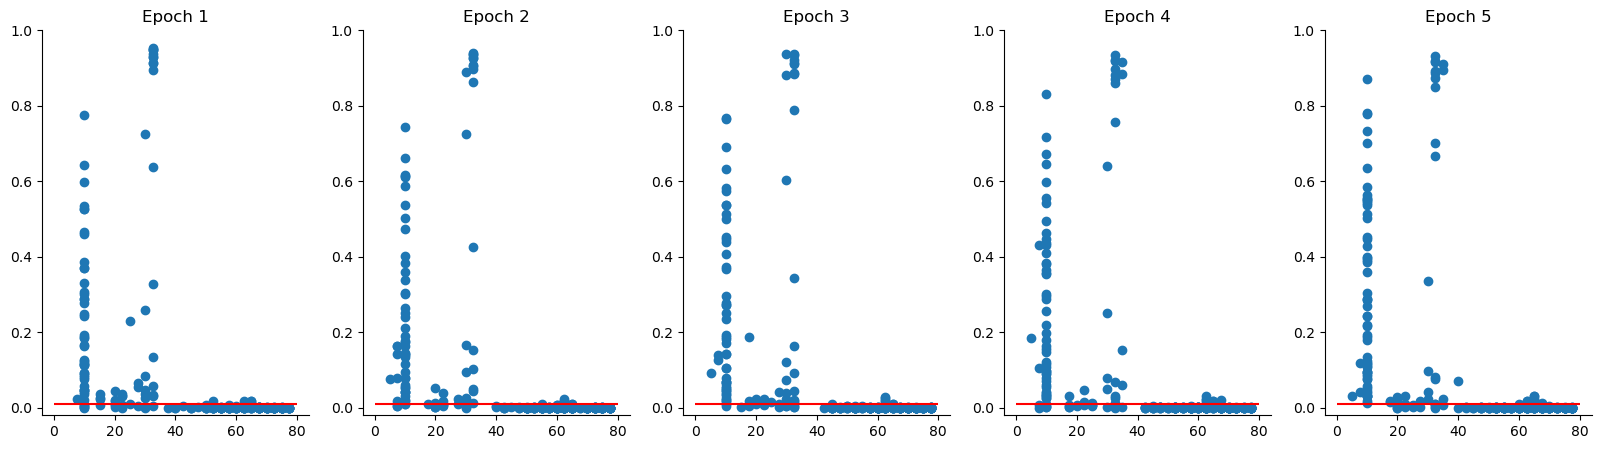

In [20]:
plt.figure(figsize=(20, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.scatter(np.hstack(peak_freqs[i]), np.hstack(peak_prominences[i]))
    plt.hlines(0.01, 0, 80, "r")
    plt.ylim(-0.02, 1)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(f"Epoch {i + 1}")

In [21]:
peak_freqs, peak_prominences, rois = [], [], []

for average_power_norm_ in average_power_norm:
    out1, out2, out3 = detect_peak_frequencies(average_power_norm_, prominence=0.01)
    peak_freqs += [out1]
    peak_prominences += [out2]
    rois += [out3]

In [22]:
def check_peaks(peak_freqs, peak_prominences, rois):

    has_peak = np.zeros((average_power_norm.sizes["roi"], len(bands)), dtype=bool)

    for i in tqdm(range(average_power_norm.sizes["roi"])):
        for peak in peak_freqs[i]:
            for n_band, band in enumerate(bands.keys()):
                if not has_peak[i, n_band]:
                    has_peak[i, n_band] = bands[band][0] <= peak <= bands[band][1]

    has_peak = xr.DataArray(
        has_peak,
        dims=("roi", "bands"),
        coords=(average_power_norm.roi, list(bands.keys())),
    )

    peak_freqs = xr.DataArray(
        np.hstack(peak_freqs),
        dims="roi",
        coords={"roi": np.hstack(rois)},
        name="peak_freq",
    )

    peak_prominences = xr.DataArray(
        np.hstack(peak_prominences),
        dims="roi",
        coords={"roi": np.hstack(rois)},
        name="peak_prom",
    )

    return has_peak

In [23]:
has_peaks = []
for i in range(5):
    has_peaks += [check_peaks(peak_freqs[i], peak_prominences[i], rois[i])]

100%|████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 456750.24it/s]


In [24]:
has_peaks = xr.DataArray(
    np.stack(has_peaks, axis=1).squeeze(),
    dims=("roi", "epochs"),
    coords={"roi": average_power_norm.roi.data},
)

In [25]:
rois = phi_series.roi.values
rois_s, rois_t = _extract_roi(rois, "-")

has_peaks_pairs = []

for roi_s, roi_t in zip(rois_s, rois_t):

    has_peaks_pairs += [has_peaks.sel(roi=[roi_s, roi_t]).all("roi").data]

In [26]:
has_peaks_pairs = xr.DataArray(
    has_peaks_pairs, dims=("roi", "epochs"), coords={"roi": rois}
).any("epochs")

#### Compute power envelope correlations

In [46]:
from frites.conn.conn_utils import conn_links
from frites.utils import parallel_func


def _pec(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_pec(w_x, w_y):
        # computes the correlation
        return w[:, w_x, :, :] * w[:, w_y, :, :]

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_pec, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def power_envelope_correlations(power, n_jobs=1, verbose=False, shuffle=False):

    # Extract dimensions
    dims = power.dims
    trials, roi, freqs = power.trials.data, power.roi.data, power.freqs.data
    ntrials, nroi, nfreqs, ntimes = power.shape

    roi_gp, roi_idx = roi, np.arange(nroi).reshape(-1, 1)
    (x_s, x_t), roi_p = conn_links(roi_gp, {})
    n_pairs = len(x_s)

    # z-score data and parse to numpy
    z_power = ((power - power.mean("times")) / power.std("times")).data

    if shuffle:
        z_power = shuffle_along_axis(z_power, 0)

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    pec = _pec(z_power, x_s, x_t, kw_para)
    pec = np.stack(pec, axis=1)

    # conversion
    pec = xr.DataArray(
        pec,
        dims=dims,
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )

    return pec

In [28]:
from frites.conn.conn_utils import conn_links
from frites.utils import parallel_func


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def _int(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_int(w_x, w_y):
        # computes fraciton of events above threshold that intersect
        x = w[:, w_x, :, :]
        y = w[:, w_y, :, :]
        prod = x * y
        norm = np.max([x.sum(-1), y.sum(-1)], axis=0)
        norm = np.where(norm == 0, 1, norm)
        return prod

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_int, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def power_events_coincidence(
    power, q_l, q_u=None, n_jobs=1, verbose=False, shuffle=False
):

    # Extract dimensions
    dims = power.dims
    trials, roi, freqs = power.trials.data, power.roi.data, power.freqs.data
    ntrials, nroi, nfreqs, ntimes = power.shape

    roi_gp, roi_idx = roi, np.arange(nroi).reshape(-1, 1)
    (x_s, x_t), roi_p = conn_links(roi_gp, {})
    n_pairs = len(x_s)

    quantiles = power.quantile(q_l, "times")

    z_power = (power >= quantiles).values

    if isinstance(q_u, float):
        quantiles = power.quantile(q_u, "times")
        z_power = np.logical_and(z_power, power < quantiles).values

    if shuffle:
        z_power = shuffle_along_axis(z_power, 0)

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    pec = _int(z_power, x_s, x_t, kw_para)
    pec = np.stack(pec, axis=1)

    # conversion
    pec = xr.DataArray(
        pec,
        dims=dims,
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )

    return pec

In [29]:
pec = power_envelope_correlations(power_time_series, 0.0)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [30]:
pec_shuffle = power_events_coincidence(power_time_series, 0.6, shuffle=True)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [47]:
pec = power_envelope_correlations(power_time_series)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [48]:
pec_shuffle = power_envelope_correlations(power_time_series, shuffle=True)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

#### Compute phase relations

In [50]:
filtered_phi_series = xr.DataArray(
    np.where(~pec, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

KeyboardInterrupt: 

In [32]:
filtered_phi_series_shuffle = xr.DataArray(
    np.where(~pec_shuffle, np.nan, phi_series_surr),
    dims=phi_series.dims,
    coords=phi_series_surr.coords,
)

In [58]:
filtered_phi_series = xr.DataArray(
    np.where(np.zeros_like(phi_series, dtype=bool), np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [59]:
filtered_phi_series_shuffle = xr.DataArray(
    np.where(np.zeros_like(phi_series, dtype=bool), np.nan, phi_series_surr),
    dims=phi_series.dims,
    coords=phi_series_surr.coords,
)

In [60]:
edges = phi_series.roi.data

In [61]:
roi_s, roi_t = _extract_roi(edges, "-")

In [62]:
np.where(roi_s == "F1_83")[0][:15]

array([ 190,  570,  643,  993, 1060, 1318, 1441, 1618, 1675, 1731, 1786,
       2096, 2098, 2099, 2119])

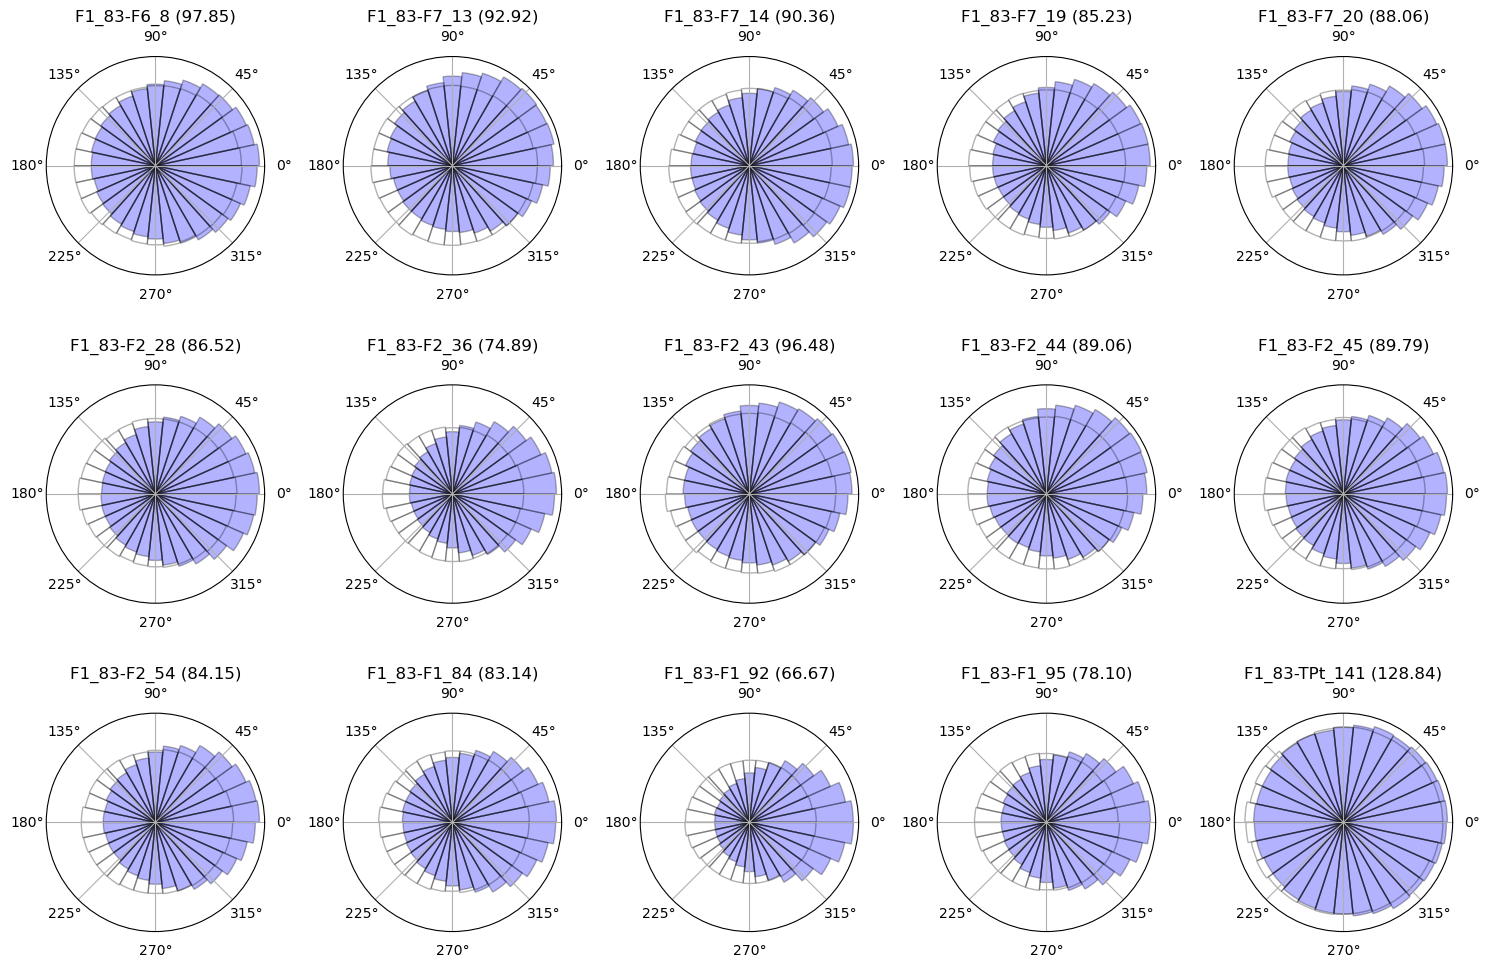

In [63]:
plt.figure(figsize=(15, 10))

for pp, pos in enumerate(np.where(roi_s == "F1_83")[0][:15]):

    ax = plt.subplot(3, 5, pp + 1, projection="polar")

    out = filtered_phi_series.sel(freqs=fc, roi=edges[pos]).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )
    m_1, m_2 = pycircular.stats.periodic_mean_std(out.data)

    out = filtered_phi_series_shuffle.sel(freqs=fc, roi=edges[pos]).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=False,
    )
    plt.title(f"{edges[pos]} ({(m_2 * 180 / np.pi):.2f})")

plt.tight_layout()


plt.savefig(f"figures/band{band}/phase_distribution_examples_band{band}.pdf")

In [64]:
std = [
    scipy.stats.circstd(filtered_phi_series.isel(roi=i, freqs=0), nan_policy="omit")
    for i in tqdm(range(filtered_phi_series.sizes["roi"]))
]

std = xr.DataArray(std, dims="roi", coords=(edges,))

100%|███████████████████████████████████████████████████████████████████████| 3321/3321 [00:18<00:00, 182.47it/s]


In [65]:
std_shuffle = [
    scipy.stats.circstd(
        filtered_phi_series_shuffle.isel(roi=i, freqs=0), nan_policy="omit"
    )
    for i in tqdm(range(filtered_phi_series_shuffle.sizes["roi"]))
]
std_shuffle = xr.DataArray(std_shuffle, dims="roi", coords=(edges,))

100%|███████████████████████████████████████████████████████████████████████| 3321/3321 [00:18<00:00, 182.49it/s]


In [66]:
x = pec.squeeze()
d = np.zeros((398, 3321))
for i in tqdm(range(398)):
    for k in range(3321):
        d[i, k] = find_activation_sequences(x[i, k]).mean()

d = xr.DataArray(
    d,
    dims=("trials", "roi"),
    coords=(
        pec.trials.values,
        pec.roi.values,
    ),
)

  0%|                                                                                    | 0/398 [00:00<?, ?it/s]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1347 and the array at index 1 has size 1304

In [ ]:
x = pec_shuffle.squeeze()
d_shuffle = np.zeros((398, 3321))
for i in tqdm(range(398)):
    for k in range(3321):
        d_shuffle[i, k] = find_activation_sequences(x[i, k]).mean()

d_shuffle = xr.DataArray(
    d_shuffle,
    dims=("trials", "roi"),
    coords=(
        pec_shuffle.trials.values,
        pec_shuffle.roi.values,
    ),
)

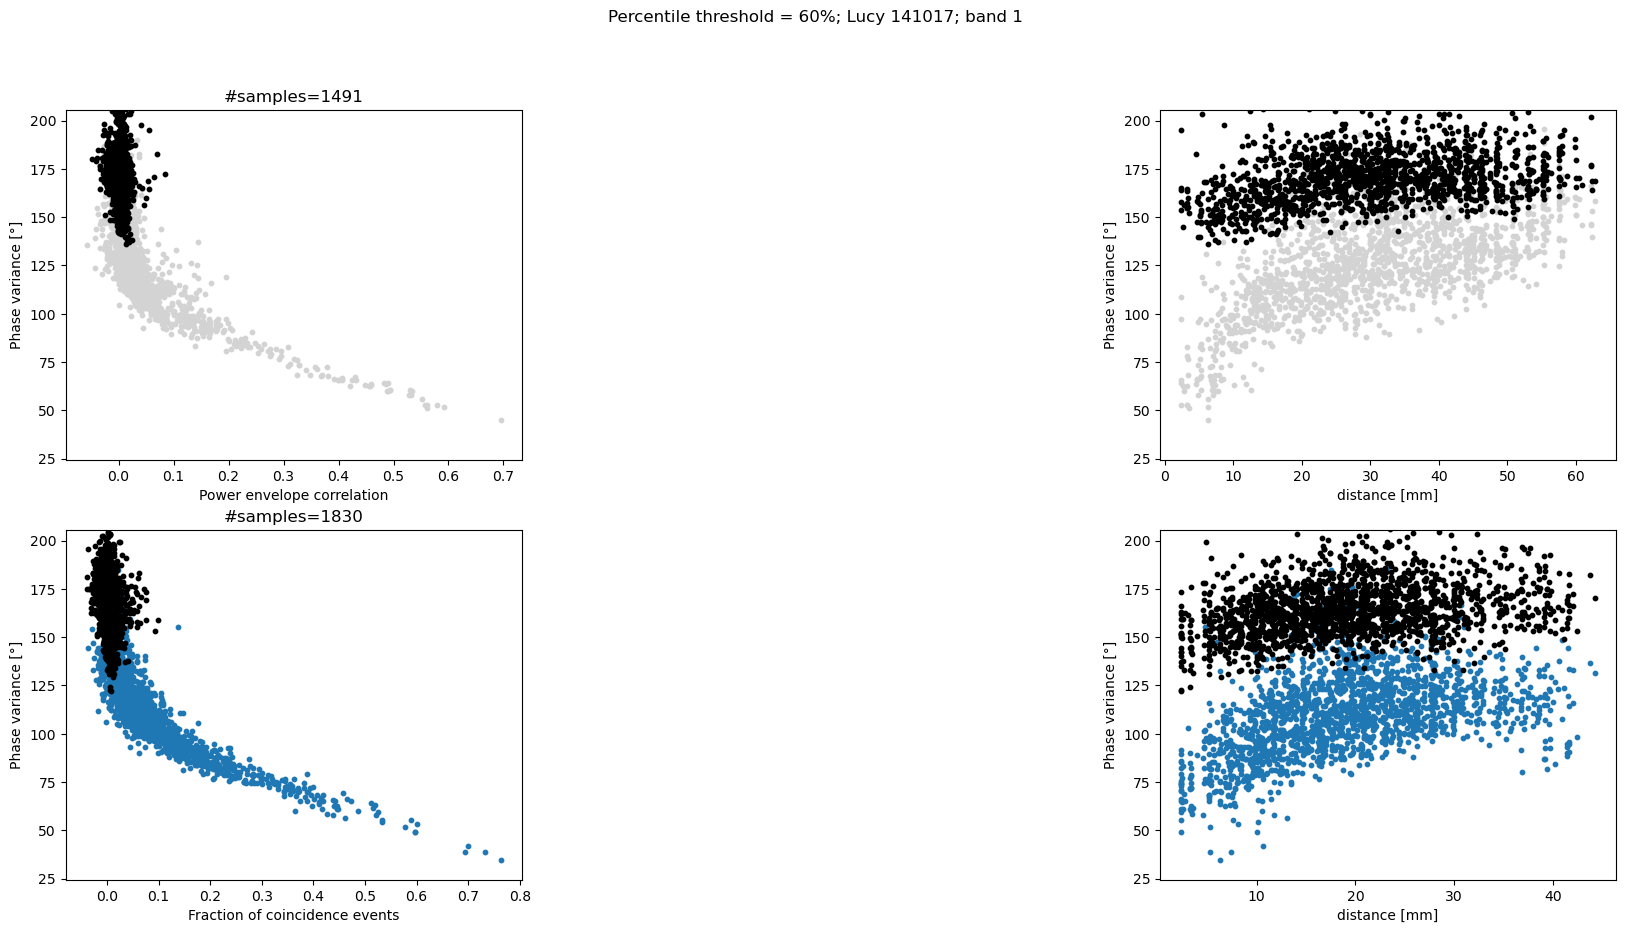

In [69]:
plt.figure(figsize=(20, 10))

ymin, ymax = std.min() * 180 / np.pi - 10, std.max() * 180 / np.pi + 10

plt.subplot(231)
plt.scatter(
    pec.mean(("trials", "times")).squeeze().isel(roi=~has_peaks_pairs.values),
    std.isel(roi=~has_peaks_pairs.values) * 180 / np.pi,
    c="lightgray",
    s=10,
)
plt.scatter(
    pec_shuffle.mean(("trials", "times")).squeeze().isel(roi=~has_peaks_pairs.values),
    std_shuffle.isel(roi=~has_peaks_pairs.values) * 180 / np.pi,
    c="k",
    s=10,
)
plt.xlabel("Power envelope correlation")
plt.ylabel("Phase variance [°]")
plt.ylim(ymin, ymax)
plt.title(f"#samples={np.logical_not(has_peaks_pairs.values).sum()}")

plt.subplot(234)
plt.scatter(
    pec.mean(("trials", "times")).squeeze().isel(roi=has_peaks_pairs.values),
    std.isel(roi=has_peaks_pairs.values) * 180 / np.pi,
    s=10,
)
plt.scatter(
    pec_shuffle.mean(("trials", "times")).squeeze().isel(roi=has_peaks_pairs.values),
    std_shuffle.isel(roi=has_peaks_pairs.values) * 180 / np.pi,
    c="k",
    s=10,
)
plt.xlabel("Fraction of coincidence events")
plt.ylabel("Phase variance [°]")
plt.ylim(ymin, ymax)
plt.title(f"#samples={has_peaks_pairs.values.sum()}")



plt.subplot(233)


plt.scatter(
    distances.isel(roi=~has_peaks_pairs.values),
    std.isel(roi=~has_peaks_pairs.values) * 180 / np.pi,
    c="lightgray",
    s=10,
)

plt.scatter(
    distances.isel(roi=~has_peaks_pairs.values),
    std_shuffle.isel(roi=~has_peaks_pairs.values) * 180 / np.pi,
    c="k",
    s=10,
)

plt.xlabel("distance [mm]")
plt.ylabel("Phase variance [°]")
plt.ylim(ymin, ymax)

plt.subplot(236)
plt.scatter(
    distances.isel(roi=has_peaks_pairs.values),
    std.isel(roi=has_peaks_pairs.values) * 180 / np.pi,
    s=10,
)

plt.scatter(
    distances.isel(roi=has_peaks_pairs.values),
    std_shuffle.isel(roi=has_peaks_pairs.values) * 180 / np.pi,
    s=10,
    c="k",
)

plt.xlabel("distance [mm]")
plt.ylabel("Phase variance [°]")
plt.ylim(ymin, ymax)

plt.suptitle(f"Percentile threshold = 60%; Lucy 141017; band {band}")

plt.savefig(f"figures/band{band}/phase_variance_dependence_band{band}.pdf")

In [42]:
d_0, d_1 = 0, 5
q1, q2 = [], []
for i in tqdm(range(13)):
    mask = np.logical_and(distances >= d_0, distances < d_1)
    x = pec_shuffle.mean(("trials", "times")).isel(roi=mask)
    q1.append(x.quantile(0.05))
    q2.append(x.quantile(0.99))
    d_0 = d_1
    d_1 += 5

100%|████████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.02s/it]


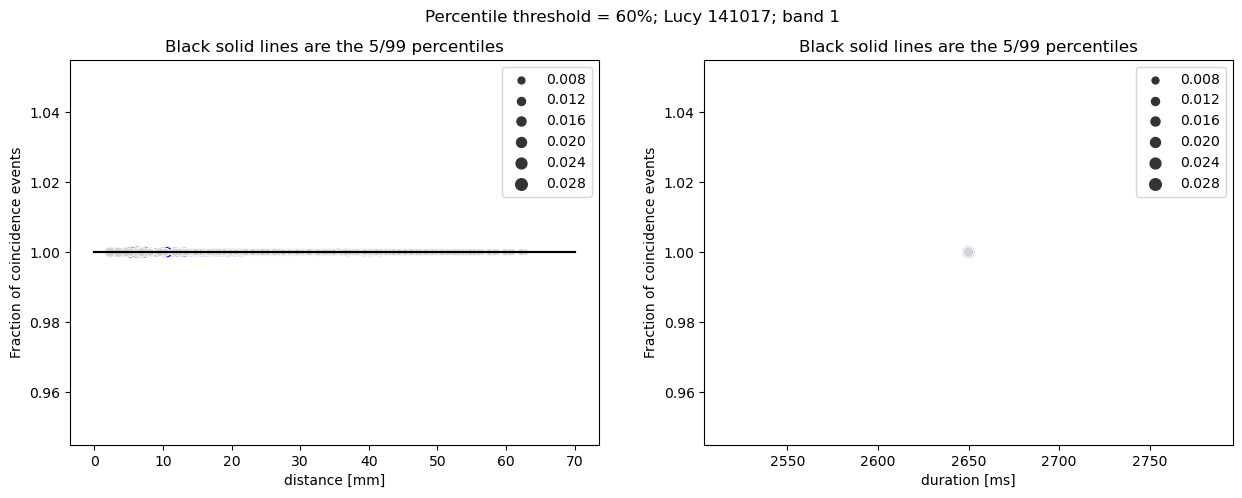

In [43]:
plt.figure(figsize=(15, 5))


plt.subplot(121)

c = []
for i in has_peaks_pairs.values:
    if i:
        c += ["b"]
    else:
        c += ["lightgray"]

plt.plot(np.linspace(0, 70, 13), q1, "k")
plt.plot(np.linspace(0, 70, 13), q2, "k")

sns.scatterplot(
    x=distances,
    y=pec.mean(("trials", "times")).squeeze(),
    c=c,
    size=1 / (std * 180 / np.pi),
)

plt.xlabel("distance [mm]")
plt.ylabel("Fraction of coincidence events")
plt.title(f"Black solid lines are the 5/99 percentiles")
plt.suptitle(f"Percentile threshold = 60%; Lucy 141017; band {band}")

plt.subplot(122)


sns.scatterplot(
    x=d.mean("trials"),
    y=pec.mean(("trials", "times")).squeeze(),
    c=c,
    size=1 / (std * 180 / np.pi),
)

plt.xlabel("duration [ms]")
plt.ylabel("Fraction of coincidence events")
plt.title(f"Black solid lines are the 5/99 percentiles")
plt.suptitle(f"Percentile threshold = 60%; Lucy 141017; band {band}")


plt.savefig(
    f"figures/band{band}/fraction_of_coincidence_versus_distance_band{band}.pdf"
)

#### Phase relations and dependence on power quantile

In [39]:
coherence = []
for i in range(9):

    pec = power_events_coincidence(
        power_time_series, 0.0 + 0.1 * i, 0.1 + 0.1 * i, verbose=False
    )

    circular_std = []

    filtered_phi_series = xr.DataArray(
        np.where(~pec, np.nan, phi_series),
        dims=phi_series.dims,
        coords=phi_series.coords,
    )

    for pos in range(phi_series.sizes["roi"]):

        out = filtered_phi_series.sel(freqs=fc, roi=edges[pos]).data
        m_2 = scipy.stats.circstd(out, nan_policy="omit")
        circular_std += [m_2 * 180 / np.pi]

    coherence += [
        xr.DataArray(circular_std, dims=("roi"), coords=(phi_series.roi.values,))
    ]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [40]:
coherence = xr.concat(coherence, "threshold")

In [41]:
x = np.arange(0.0, 0.9, 0.1)

In [42]:
slopes = [
    scipy.stats.linregress(
        x, coherence.sel(roi=distances.roi.values).T[i], "two-sided"
    )[0]
    for i in range(coherence.sizes["roi"])
]
d not get source code


pvals = [
    scipy.stats.linregress(
        x, coherence.sel(roi=distances.roi.values).T[i], "two-sided"
    )[3]
    for i in range(coherence.sizes["roi"])
]

In [43]:
slopes = xr.DataArray(slopes, dims=("roi"), coords=(edges,))

Text(0.5, 0, '#count')

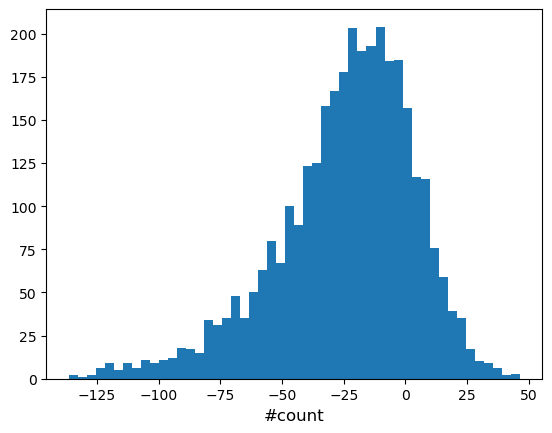

In [44]:
plt.hist(slopes, 50)
plt.xlabel("Slope of phase variance vs. power quantile", fontsize=12)
plt.xlabel("#count", fontsize=12)

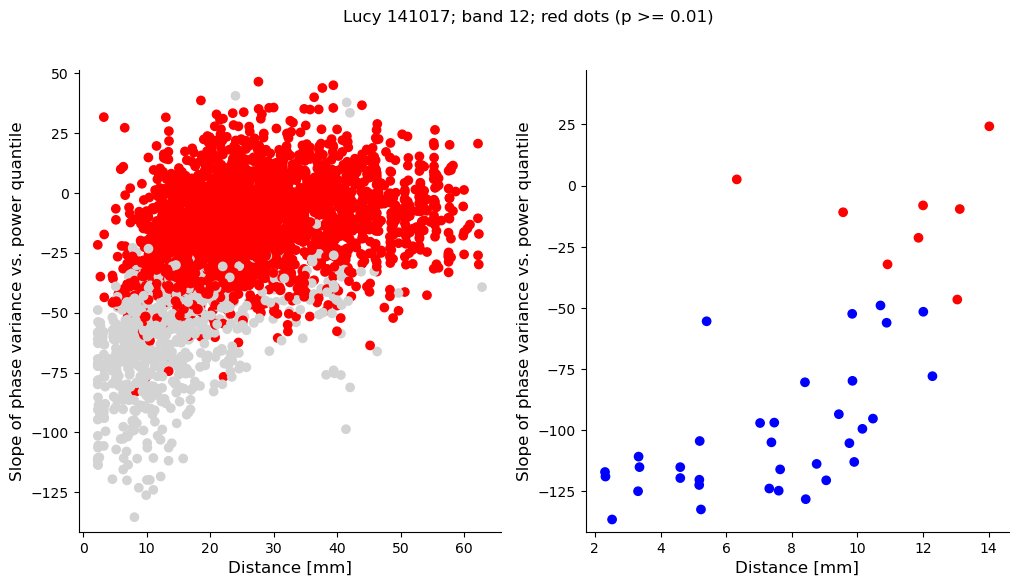

In [45]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(121)

c = []
for p in pvals:
    if p < 0.01:
        c += ["lightgray"]
    else:
        c += ["r"]
c = np.stack(c)

plt.scatter(
    distances.isel(roi=~has_peaks_pairs.values),
    slopes.isel(roi=~has_peaks_pairs.values),
    c=c[~has_peaks_pairs.values],
)
plt.ylabel("Slope of phase variance vs. power quantile", fontsize=12)
plt.xlabel("Distance [mm]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylim(slopes.min() - 5, slopes.max() + 5)

ax = plt.subplot(122)

c = []
for p in pvals:
    if p < 0.01:
        c += ["b"]
    else:
        c += ["r"]
c = np.stack(c)

plt.scatter(
    distances.isel(roi=has_peaks_pairs.values),
    slopes.isel(roi=has_peaks_pairs.values),
    c=c[has_peaks_pairs.values],
)

plt.ylabel("Slope of phase variance vs. power quantile", fontsize=12)
plt.xlabel("Distance [mm]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylim(slopes.min() - 5, slopes.max() + 1)
plt.suptitle(f"Lucy 141017; band {band}; red dots (p >= 0.01)")

plt.savefig(f"figures/band{band}/phase_slope_band{band}.pdf")

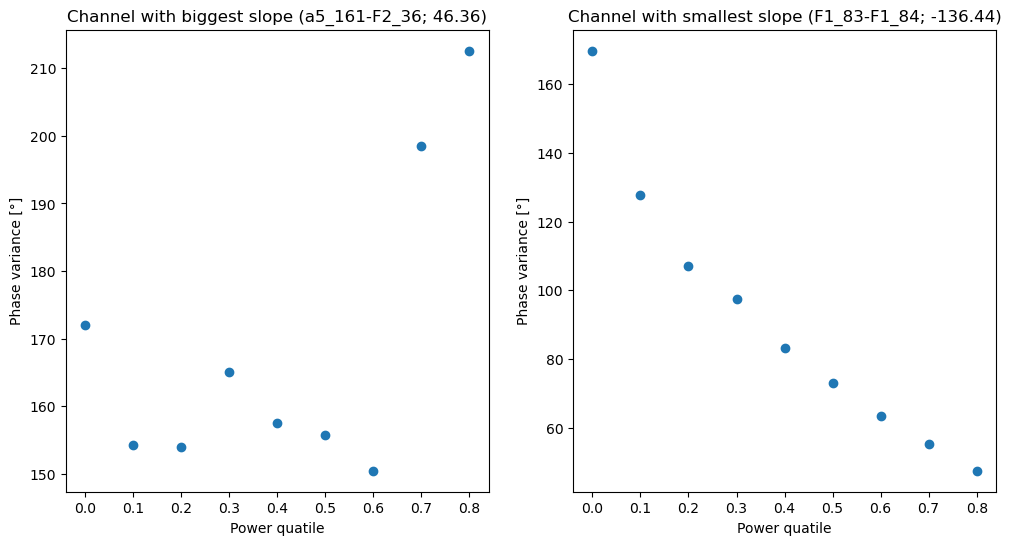

In [48]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
plt.scatter(x, coherence.sel(roi=slopes.roi.values[slopes.argmax()]).T)
plt.xlabel("Power quatile")
plt.ylabel("Phase variance [°]")
plt.title(
    f"Channel with biggest slope ({slopes.roi.values[slopes.argmax()]}; {slopes.max().values:.2f})"
)
ax = plt.subplot(122)
plt.scatter(x, coherence.sel(roi=slopes.roi.values[slopes.argmin()]).T)
plt.xlabel("Power quatile")
plt.ylabel("Phase variance [°]")
plt.title(
    f"Channel with smallest slope ({slopes.roi.values[slopes.argmin()]}; {slopes.min().values:.2f})"
)
plt.savefig(f"figures/band{band}/phase_slope_example_pairs_band{band}.pdf")

In [49]:
l = [0, 0.25, 0.50, 0.75]
u = [0.25, 0.50, 0.75, 1]

coherence = []
for i in range(4):

    pec = power_events_coincidence(power_time_series, l[i], u[i], verbose=False)

    circular_std = []

    filtered_phi_series = xr.DataArray(
        np.where(~pec, np.nan, phi_series),
        dims=phi_series.dims,
        coords=phi_series.coords,
    )

    for pos in range(phi_series.sizes["roi"]):

        out = filtered_phi_series.sel(freqs=fc, roi=edges[pos]).data
        m_2 = scipy.stats.circstd(
            filtered_phi_series.sel(freqs=fc, roi=edges[pos]), nan_policy="omit"
        )
        circular_std += [m_2 * 180 / np.pi]

    coherence += [
        xr.DataArray(circular_std, dims=("roi"), coords=(phi_series.roi.values,))
    ]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

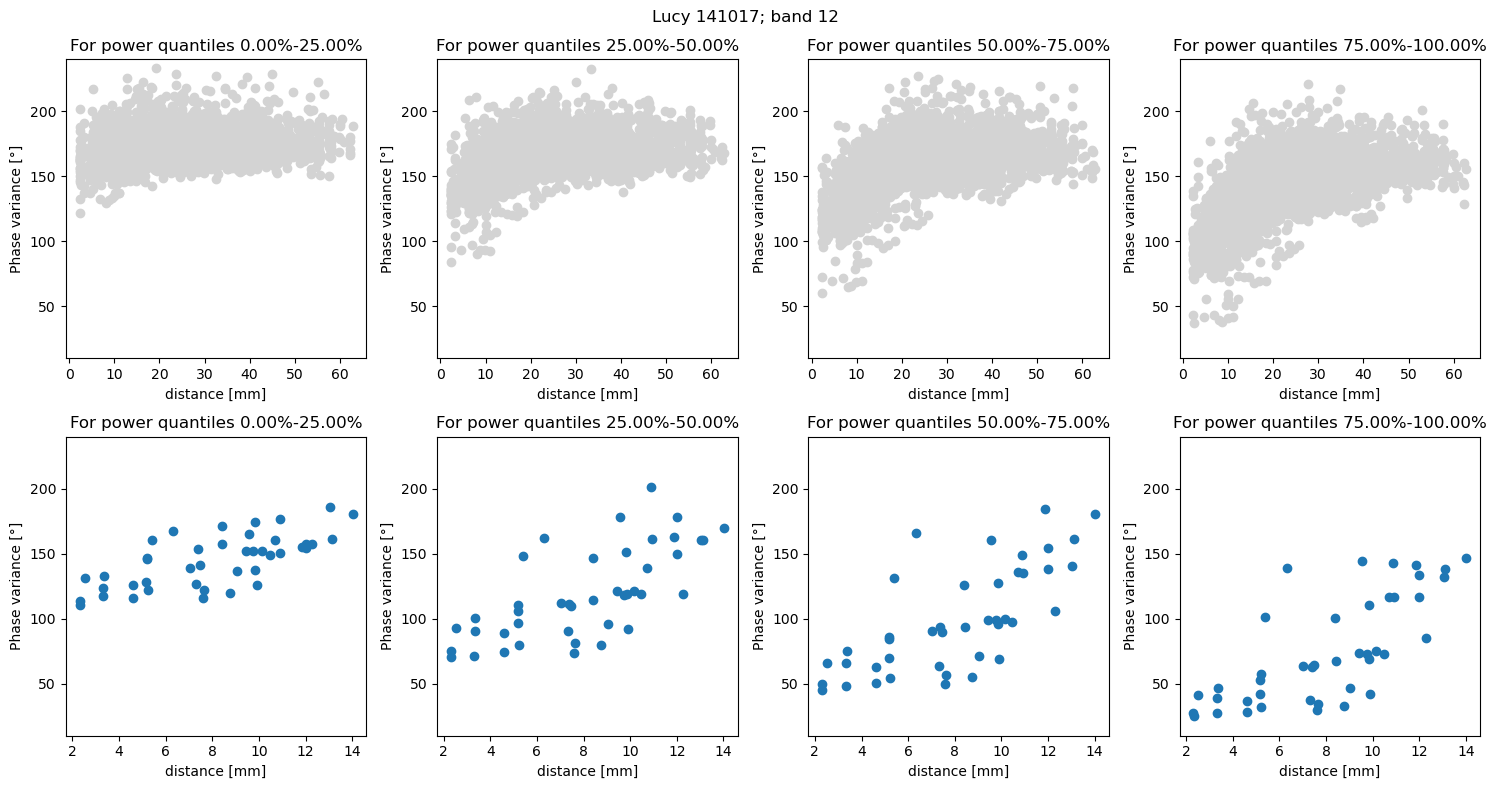

In [50]:
plt.figure(figsize=(15, 8))

for i in range(4):

    ax = plt.subplot(2, 4, i + 1)
    plt.scatter(
        distances.isel(roi=~has_peaks_pairs.values),
        coherence[i].isel(roi=~has_peaks_pairs.values),
        c="lightgray",
    )

    plt.xlabel("distance [mm]")
    plt.ylabel("Phase variance [°]")
    plt.title(f"For power quantiles {100*l[i]:.2f}%-{100*u[i]:.2f}%")
    plt.ylim(10, 240)

for i in range(4):

    ax = plt.subplot(2, 4, i + 5)
    plt.scatter(
        distances.isel(roi=has_peaks_pairs.values),
        coherence[i].isel(roi=has_peaks_pairs.values),
    )

    plt.xlabel("distance [mm]")
    plt.ylabel("Phase variance [°]")
    plt.title(f"For power quantiles {100*l[i]:.2f}%-{100*u[i]:.2f}%")
    plt.ylim(10, 240)
plt.suptitle(f"Lucy 141017; band {band}")

plt.tight_layout()

plt.savefig(f"figures/band{band}/phase_variance_quantiles_band{band}.pdf")

#### Dependence of phase variace on task epoch

In [29]:
pec = power_events_coincidence(power_time_series, 0.6)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [30]:
pec_shuffle = power_events_coincidence(power_time_series, 0.6, shuffle=True)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [31]:
filtered_phi_series = xr.DataArray(
    np.where(~pec, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [32]:
filtered_phi_series_shuffle = xr.DataArray(
    np.where(~pec_shuffle, np.nan, phi_series_surr),
    dims=phi_series.dims,
    coords=phi_series_surr.coords,
)

In [33]:
t_match_on = (
    phase_time_series.attrs["t_match_on"] - phase_time_series.attrs["t_cue_on"]
) / phase_time_series.fsample

t_match_on = np.round(t_match_on, 1)

epoch_data = []

for i in range(phase_time_series.sizes["trials"]):
    stages = [
        [-0.4, 0.0],
        [0, 0.4],
        [0.5, 0.9],
        [0.9, 1.3],
        [t_match_on[i] - 0.4, t_match_on[i]],
    ]

    temp = []

    for t_i, t_f in stages:
        temp += [filtered_phi_series[i].sel(times=slice(t_i, t_f)).data]

    epoch_data += [np.stack(temp, axis=-2)]

epoch_data = xr.DataArray(
    np.stack(epoch_data).squeeze(),
    dims=("trials", "roi", "epochs", "time"),
    coords={
        "trials": filtered_phi_series.trials,
        "roi": filtered_phi_series.roi,
    },
    attrs=phase_time_series.attrs,
)

In [34]:
t_match_on = (
    phase_time_series.attrs["t_match_on"] - phase_time_series.attrs["t_cue_on"]
) / phase_time_series.fsample

t_match_on = np.round(t_match_on, 1)

epoch_data_shuffle = []

for i in range(phase_time_series.sizes["trials"]):
    stages = [
        [-0.4, 0.0],
        [0, 0.4],
        [0.5, 0.9],
        [0.9, 1.3],
        [t_match_on[i] - 0.4, t_match_on[i]],
    ]

    temp = []

    for t_i, t_f in stages:
        temp += [filtered_phi_series_shuffle[i].sel(times=slice(t_i, t_f)).data]

    epoch_data_shuffle += [np.stack(temp, axis=-2)]

epoch_data_shuffle = xr.DataArray(
    np.stack(epoch_data_shuffle).squeeze(),
    dims=("trials", "roi", "epochs", "time"),
    coords={
        "trials": filtered_phi_series.trials,
        "roi": filtered_phi_series.roi,
    },
    attrs=phase_time_series.attrs,
)

In [35]:
slopes = [
    scipy.stats.circstd(epoch_data[:, i], axis=(0, -1), nan_policy="omit")
    for i in tqdm(range(epoch_data.sizes["roi"]))
]

slopes_mean = np.stack(slopes) * 180 / np.pi

slopes_mean = xr.DataArray(
    slopes_mean.T,
    dims=("epochs", "roi"),
    coords=(
        range(5),
        phi_series.roi.values,
    ),
)

100%|█████████████████████████████████████████████████████| 3321/3321 [02:02<00:00, 27.03it/s]


In [36]:
slopes_shuffle = [
    scipy.stats.circstd(epoch_data_shuffle[:, i], axis=(0, -1), nan_policy="omit")
    for i in tqdm(range(epoch_data_shuffle.sizes["roi"]))
]

slopes_mean_shuffle = np.stack(slopes_shuffle) * 180 / np.pi

slopes_mean_shuffle = xr.DataArray(
    slopes_mean_shuffle.T,
    dims=("epochs", "roi"),
    coords=(
        range(5),
        phi_series_surr.roi.values,
    ),
)

100%|█████████████████████████████████████████████████████| 3321/3321 [00:57<00:00, 58.12it/s]


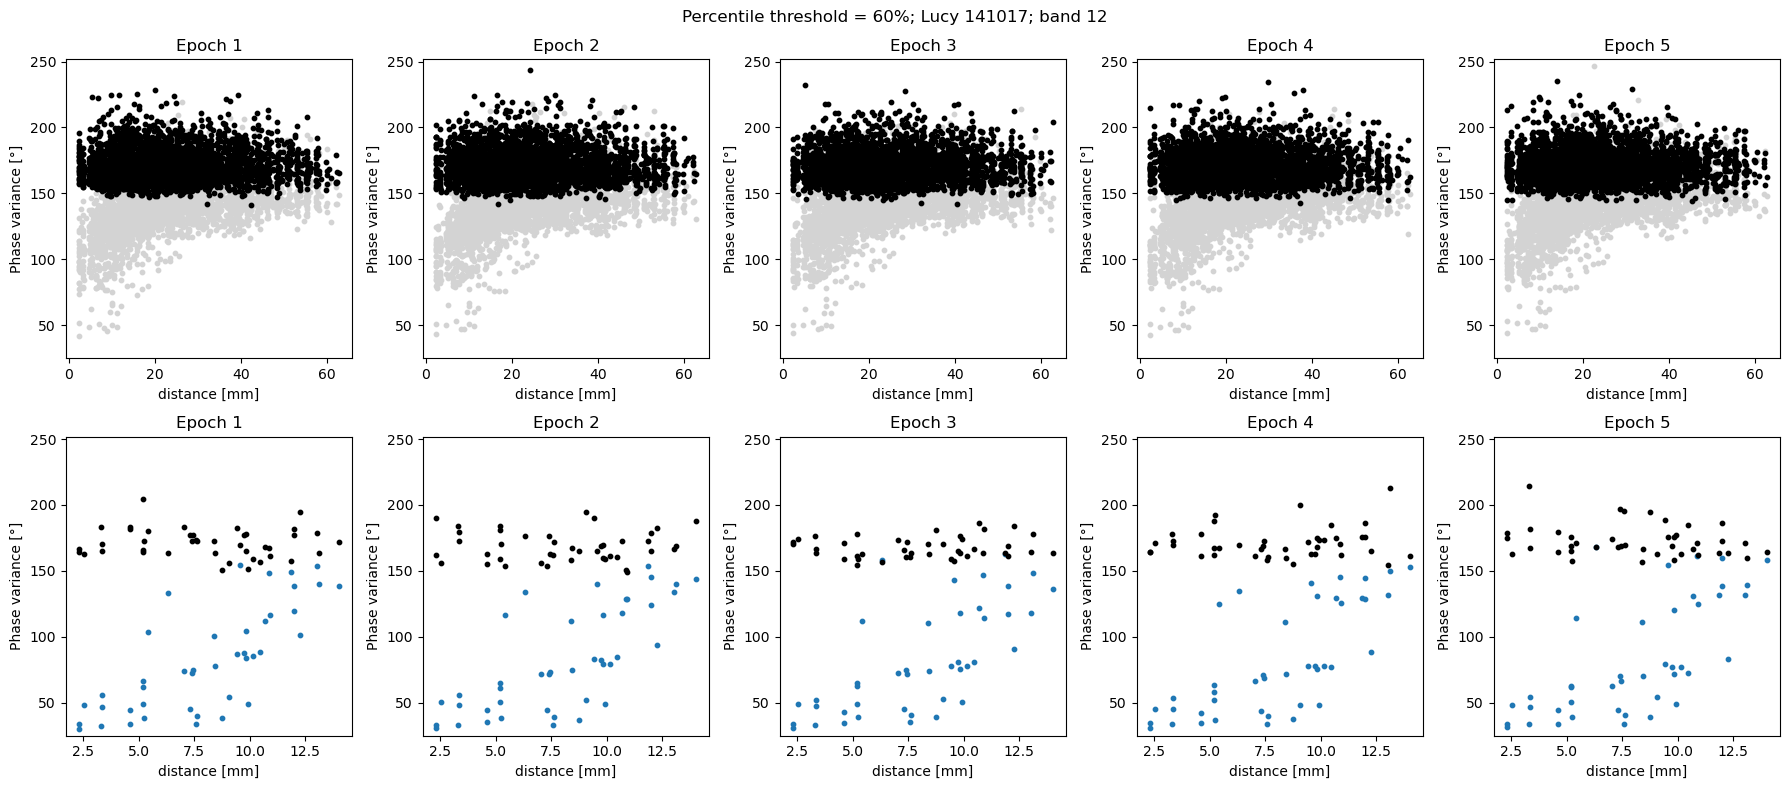

In [37]:
plt.figure(figsize=(18, 8))

for i in range(5):

    ax = plt.subplot(2, 5, i + 1)
    plt.scatter(
        distances.isel(roi=~has_peaks_pairs.values),
        slopes_mean[i].isel(roi=~has_peaks_pairs.values),
        c="lightgray",
        s=10,
    )

    plt.scatter(
        distances.isel(roi=~has_peaks_pairs.values),
        slopes_mean_shuffle[i].isel(roi=~has_peaks_pairs.values),
        c="k",
        s=10,
    )

    plt.xlabel("distance [mm]")
    plt.ylabel("Phase variance [°]")
    plt.ylim(slopes_mean.min() - 5, slopes_mean.max() + 5)
    plt.title(f"Epoch {i + 1}")

for i in range(5):

    ax = plt.subplot(2, 5, i + 6)

    plt.scatter(
        distances.isel(roi=has_peaks_pairs.values),
        slopes_mean[i].isel(roi=has_peaks_pairs.values),
        s=10,
    )

    plt.scatter(
        distances.isel(roi=has_peaks_pairs.values),
        slopes_mean_shuffle[i].isel(roi=has_peaks_pairs.values),
        c="k",
        s=10,
    )

    plt.xlabel("distance [mm]")
    plt.ylabel("Phase variance [°]")
    plt.ylim(slopes_mean.min() - 5, slopes_mean.max() + 5)
    plt.title(f"Epoch {i + 1}")

plt.suptitle(f"Percentile threshold = 60%; Lucy 141017; band {band}")

plt.tight_layout()

plt.savefig(f"figures/band{band}/phase_variance_epochs_band{band}.pdf")

#### Dependence of phase variace slope on task epoch

In [58]:
t_match_on = (
    phase_time_series.attrs["t_match_on"] - phase_time_series.attrs["t_cue_on"]
) / phase_time_series.fsample

t_match_on = np.round(t_match_on, 1)

In [ ]:
coherence = []

for i in range(9):

    # Compute power events coincidence
    pec = power_events_coincidence(
        power_time_series, 0.0 + 0.1 * i, 0.1 + 0.1 * i, verbose=False
    )

    filtered_phi_series = xr.DataArray(
        np.where(~pec, np.nan, phi_series),
        dims=phi_series.dims,
        coords=phi_series.coords,
    )

    # Break it in epochs
    epoch_data = []

    for j in range(power_time_series.sizes["trials"]):

        stages = [
            [-0.4, 0.0],
            [0, 0.4],
            [0.5, 0.9],
            [0.9, 1.3],
            [t_match_on[j] - 0.4, t_match_on[j]],
        ]

        temp = []

        for t_i, t_f in stages:
            temp += [filtered_phi_series[j].sel(times=slice(t_i, t_f)).data]

        epoch_data += [np.stack(temp, axis=-2)]

    epoch_data = np.stack(epoch_data).squeeze()

    circular_std = []

    for pos in tqdm(range(phi_series.sizes["roi"])):

        m_2 = scipy.stats.circstd(epoch_data[:, pos], axis=(0, -1), nan_policy="omit")
        circular_std += [m_2 * 180 / np.pi]

    coherence += [
        xr.DataArray(
            circular_std,
            dims=("roi", "epochs"),
            coords={
                "roi": phi_series.roi.values,
            },
        )
    ]

    del pec, filtered_phi_series, epoch_data

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [ ]:
coherence = xr.concat(coherence, "quantiles")

In [ ]:
x = np.arange(0, 0.9, 0.1)

In [ ]:
slopes = []
for j in tqdm(range(5)):
    slopes += [
        [
            scipy.stats.linregress(
                x, coherence.sel(roi=distances.roi.values, epochs=j).T[i], "two-sided"
            )[0]
            for i in range(coherence.sizes["roi"])
        ]
    ]

In [ ]:
pvals = []
for j in tqdm(range(5)):
    pvals += [
        [
            scipy.stats.linregress(
                x, coherence.sel(roi=distances.roi.values, epochs=j).T[i], "two-sided"
            )[3]
            for i in range(coherence.sizes["roi"])
        ]
    ]

In [ ]:
slopes = xr.DataArray(
    slopes,
    dims=("epochs", "roi"),
    coords=(
        range(5),
        phi_series.roi.values,
    ),
)

In [ ]:
plt.figure(figsize=(20, 10))
for j in tqdm(range(5)):
    ax = plt.subplot(2, 5, j + 1)

    c = []
    for p in pvals[j]:
        if p < 0.01:
            c += ["lightgray"]
        else:
            c += ["r"]
    c = np.stack(c)

    plt.scatter(
        distances.isel(roi=~has_peaks_pairs.values),
        slopes[j].isel(roi=~has_peaks_pairs.values),
        s=10,
        c=c[~has_peaks_pairs.values],
    )
    plt.title(f"Epoch {j + 1}", fontsize=12)
    plt.xlabel("distance [mm]", fontsize=12)
    plt.ylabel("Slope of phase variance vs. power quantile", fontsize=12)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]

for j in tqdm(range(5)):
    ax = plt.subplot(2, 5, j + 6)

    c = []
    for p in pvals[j]:
        if p < 0.01:
            c += ["b"]
        else:
            c += ["r"]
    c = np.stack(c)

    plt.scatter(
        distances.isel(roi=has_peaks_pairs.values),
        slopes[j].isel(roi=has_peaks_pairs.values),
        s=10,
        c=c[has_peaks_pairs.values],
    )
    plt.title(f"Epoch {j + 1}", fontsize=12)
    plt.xlabel("distance [mm]", fontsize=12)
    plt.ylabel("Slope of phase variance vs. power quantile", fontsize=12)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.suptitle(f"Lucy 141017; band {band}; red dots (p >= 0.01)")

plt.tight_layout()

plt.savefig(f"figures/band{band}/phase_slope_epochs_band{band}.pdf")